In [ ]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
#from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Concatenate, Activation, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk
from sklearn.model_selection import train_test_split

from keras.layers import Concatenate
from keras.layers import Activation, Dense
from keras.layers import Input, Dropout
from keras.layers import concatenate
from keras.layers import Add
from keras.utils.vis_utils import plot_model
from keras.models import Model
from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Bidirectional , TimeDistributed
from keras.layers.merge import add

from keras.models import load_model

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from nltk.translate.bleu_score import sentence_bleu

import string
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In case of testing, set PATH variables to your files.

In [ ]:
DATASET_PATH = "drive/MyDrive/flickr8/captions.txt"
IMAGES_PATH = "drive/MyDrive/flickr8/Images/"
ENCODED_DICT = "drive/MyDrive/flickr8/encoded_train_inception.p"
TRAIN_PATH = "drive/MyDrive/flickr8/train_csv.csv"
TEST_PATH = "drive/MyDrive/flickr8/test_csv.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with (open(ENCODED_DICT, "rb")) as file:
    encoded_dict = pickle.load(file)

In [ ]:
df = pd.read_csv(DATASET_PATH)

In [ ]:
def cleaning_text(caption):
    table = str.maketrans('','',string.punctuation)
    
    caption.replace("-"," ")
    desc = caption.split()
    desc = [word.lower() for word in desc]
    desc = [word.translate(table) for word in desc]
    desc = [word for word in desc if(len(word)>1)]
    desc = [word for word in desc if(word.isalpha())]
    caption = ' '.join(desc)
    return caption

In [ ]:
def create_df_by_img(df):
  captions_per_image = {}

  for index, row in df.iterrows():
    caption = row["caption"]
    if row["image"] in captions_per_image:
      captions_per_image[row["image"]].append("<start> " + caption + " <end>")
      continue
    captions_per_image[row["image"]] = ["<start> " + caption + " <end>"]
  return captions_per_image

In [ ]:
caps_per_img = create_df_by_img(df)

In [ ]:
captions = []
for key, val in caps_per_img.items():
    for i in val:
        captions.append(i)

In [ ]:
words = [i.split() for i in captions]
vocabulary = []
for i in words:
    vocabulary.extend(i)

vocabulary = list(set(vocabulary))

In [ ]:
len(vocabulary)

9632

In [ ]:
word2idx = {val:index for index, val in enumerate(vocabulary)}

idx2word = {index:val for index, val in enumerate(vocabulary)}

In [ ]:
idx2word[2561]

'helmets'

In [ ]:
max_len = 0
for c in captions:
    c = c.split()

    if len(c) > max_len:
        max_len = len(c)
        
max_len

40

In [ ]:
samples_per_epoch = 0

for ca in captions:
    samples_per_epoch += len(ca.split())-1

samples_per_epoch    

517120

In [ ]:

def model(vocab_size, max_len, embedding_size = 300):

    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.2)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)

    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.2)(se1)
    se3 = LSTM(256 , return_sequences= True)(se2)
    se4 = TimeDistributed(Dense(300))(se3)

    decoder1 = Add()([fe2, se4])
    se4 = Dropout(0.2)(decoder1)
    se5 = LSTM(256, return_sequences= True)(se4)
    se6 = LSTM(256)(se5)
    decoder2 = Dense(256, activation='relu')(se6)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop',metrics=['accuracy'])

    model.summary()
    
    return model

In [ ]:
captioning_model3 = model(len(vocabulary), 40)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 300)      2889600     ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_1 (Dropout)            (None, 40, 300)      0           ['embedding[0][0]']              
                                                                                              

In [ ]:
caps_per_img["1000268201_693b08cb0e.jpg"]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [ ]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        df_train = pd.read_csv(TRAIN_PATH)
        df_train = df_train.sample(frac=1)
        iter = df_train.iterrows()
        c = []
        imgs = []
        for _, row in df_train.iterrows():
            c.append(row["captions"])
            imgs.append(row["image_id"])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoded_dict[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(len(vocabulary))
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [ ]:
len(encoded_dict['3118425885_f0cc035032.jpg'])
df_train = pd.read_csv(TRAIN_PATH)
df_train.columns


Index(['image_id', 'captions'], dtype='object')

In [ ]:
batch_size = 512
captioning_model3.fit_generator(data_generator(batch_size), steps_per_epoch=(samples_per_epoch/batch_size), epochs=20, 
                          verbose=1)


In [ ]:
captioning_model3.save_weights('model11_inc_lstm_weights.h5')
captioning_model3.save('model11_inc_lstm.h5')



In [ ]:
def predict_cap(model, image):
  start_word = ["<start>"]

  while True:
      par_caps = [word2idx[i] for i in start_word]
      par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
      try:
        e = encoded_dict[image]
      except:
        continue

      preds = model.predict([np.array([e]), np.array(par_caps)])
      p = np.argmax(preds[0])
      word_pred = idx2word[p]
      start_word.append(word_pred)
      
      if word_pred == "<end>" or len(start_word) > max_len:
          break
          
  return ' '.join(start_word[1:-1])

In [ ]:
# print(encoded_dict["873633312_a756d8b381.jpg"])
print(caps_per_img["2351479551_e8820a1ff3.jpg"])
predict_cap(captioning_model3, "2351479551_e8820a1ff3.jpg")

['<start> A boy wearing blue shorts is doing a back flip in the air under a tree . <end>', '<start> A man in midair doing a flip . <end>', '<start> a young man jumping a back flip off of a concrete wall . <end>', '<start> Man with blue pants flipping in the air . <end>', '<start> The boy wearing blue pants is in the midst of a back flip . <end>']


'<start> A boy in a red shirt is jumping on a trampoline . <end>'

In [ ]:
pred_dict_m1 = {}
df_test = pd.read_csv(TEST_PATH)
print(df_test.columns)
for _, row in df_test.iterrows():
    pred_sent = predict_cap(captioning_model3, row["image_id"])
    pred_dict_m1[row["image_id"]] = word_tokenize(pred_sent)


KeyboardInterrupt



In [ ]:
pred1_df = pd.DataFrame.from_dict(pred_dict_m1, orient="index")
pred1_df.to_csv("pred4_df.csv")

Evaluation


In [ ]:
caps_per_test = {}
for _, row in df_test.iterrows():
  img = row["image_id"]
  caps_per_test[img] = caps_per_img[img]

In [ ]:
from google.colab import files
files.download("pred4_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
score_m1 = {}

for image in pred_dict_m1:
    sent_list = []
    pred_cap = pred_dict_m1[image]
    for sent in caps_per_test[image]:
        sent1 = sent.split()
        sent_list.append(sent1[1:-1])
    score = sentence_bleu(sent_list, pred_cap[3:-3], weights=(1, 0, 0, 0))
    score_m1[image] = score


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
bleu_val = 0
for it in score_m1.values():
    bleu_val += it

bleu_val / 1000


0.566423813832438

In [ ]:
print(pred_dict_m1["2285570521_05015cbf4b.jpg"][3:-3])

['A', 'person', 'is', 'skiing', 'down', 'a', 'snowy', 'hill', '.']


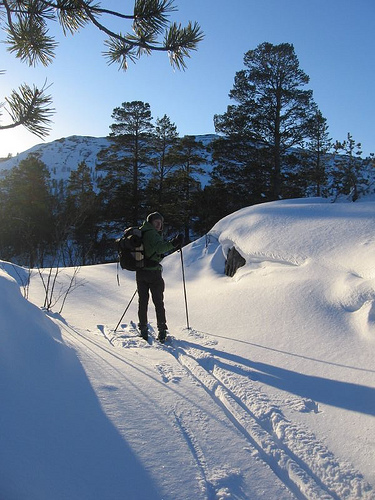

In [ ]:
Image.open(IMAGES_PATH + "2285570521_05015cbf4b.jpg")

In [ ]:
files.download("model11_inc_lstm.h5")
files.download("model11_inc_lstm_weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>